# FID and SSIM Calculator

Based on the original medgan_evaluation notebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Set the stage with necessary imports and objects

In [ ]:
import kagglehub
import os
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import cv2
import matplotlib.pyplot as plt
from torch.autograd import Variable
from keras.applications import InceptionV3
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, recall_score, precision_score
from scipy.linalg import sqrtm
import torch.nn.functional as F
import torchvision.models as models

In [ ]:
# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [ ]:
path = path + "/chest_xray/"

train_path = path + "train/"
test_path = path + "test/"
val_path = path + "val/"

In [ ]:
# check original image sizes

img_size_check = cv2.imread(train_path + 'NORMAL/NORMAL2-IM-0389-0001.jpeg')

print(img_size_check.shape)

(1136, 1484, 3)


In [ ]:
# Hyperparameters
image_size = 128
batch_size = 64
n_classes = 2
lr = 2e-4
beta1, beta2 = 0.5, 0.999
latent_dim = 100
n_epochs = 200
sample_interval = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, n_classes=2, img_channels=1, feature_maps=64):
        super().__init__()
        self.label_emb = nn.Embedding(n_classes, n_classes)
        input_dim = latent_dim + n_classes
        ds_factor = image_size // 16
        proj_dim = feature_maps * 8 * ds_factor * ds_factor

        self.net = nn.Sequential(
            # project and reshape
            nn.Linear(input_dim, proj_dim),
            nn.BatchNorm1d(proj_dim),
            nn.ReLU(True),
            nn.Unflatten(1, (feature_maps*8, ds_factor, ds_factor)),

            # upsampling blocks
            nn.ConvTranspose2d(feature_maps*8, feature_maps*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_maps*4, feature_maps*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_maps*2, feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(True),

            # final grayscale output
            nn.ConvTranspose2d(feature_maps, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # embed labels and concatenate
        c = self.label_emb(labels)
        x = torch.cat([noise, c], dim=1)
        return self.net(x)

In [ ]:
# Dataloading
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

### Comparison Time

In [ ]:
# reload model only if you really need to
path_to_DLmedgan = '/content/drive/MyDrive/Georgia Tech Documents/CS 7643/DL medGAN Project' # change based on your directory

# path_to_acgan = path_to_DLmedgan + '/acgan_model_v3_2/acgan_model_v3_2.pth'

path_to_acgan = path_to_DLmedgan + '/logs/baseline/checkpoint_epoch_99.pt'

acgan = torch.load(path_to_acgan, weights_only=True)

acgan_G = Generator(latent_dim, n_classes, 3).to(device)
acgan_G.load_state_dict(acgan['generator_state_dict'])
# acgan_G.load_state_dict(acgan['generator'])  # to use with model_v3_2
acgan_G.eval()

# load medgan
path_to_medganx = path_to_DLmedgan + '/logs/medganx/checkpoint_epoch_99.pt'

medganx = torch.load(path_to_medganx, weights_only=True)

# print(medganx['generator_state_dict'])

medganx_G = Generator(latent_dim, n_classes, 3).to(device)
medganx_G.load_state_dict(medganx['generator_state_dict'])
medganx_G.eval()

# print(model['generator'])

Generator(
  (label_emb): Embedding(2, 2)
  (net): Sequential(
    (0): Linear(in_features=102, out_features=32768, bias=True)
    (1): BatchNorm1d(32768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Unflatten(dim=1, unflattened_size=(512, 8, 8))
    (4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): ConvTranspose2d(64, 3, kernel_size=(4,

torch.Size([64, 100])
torch.Size([64])


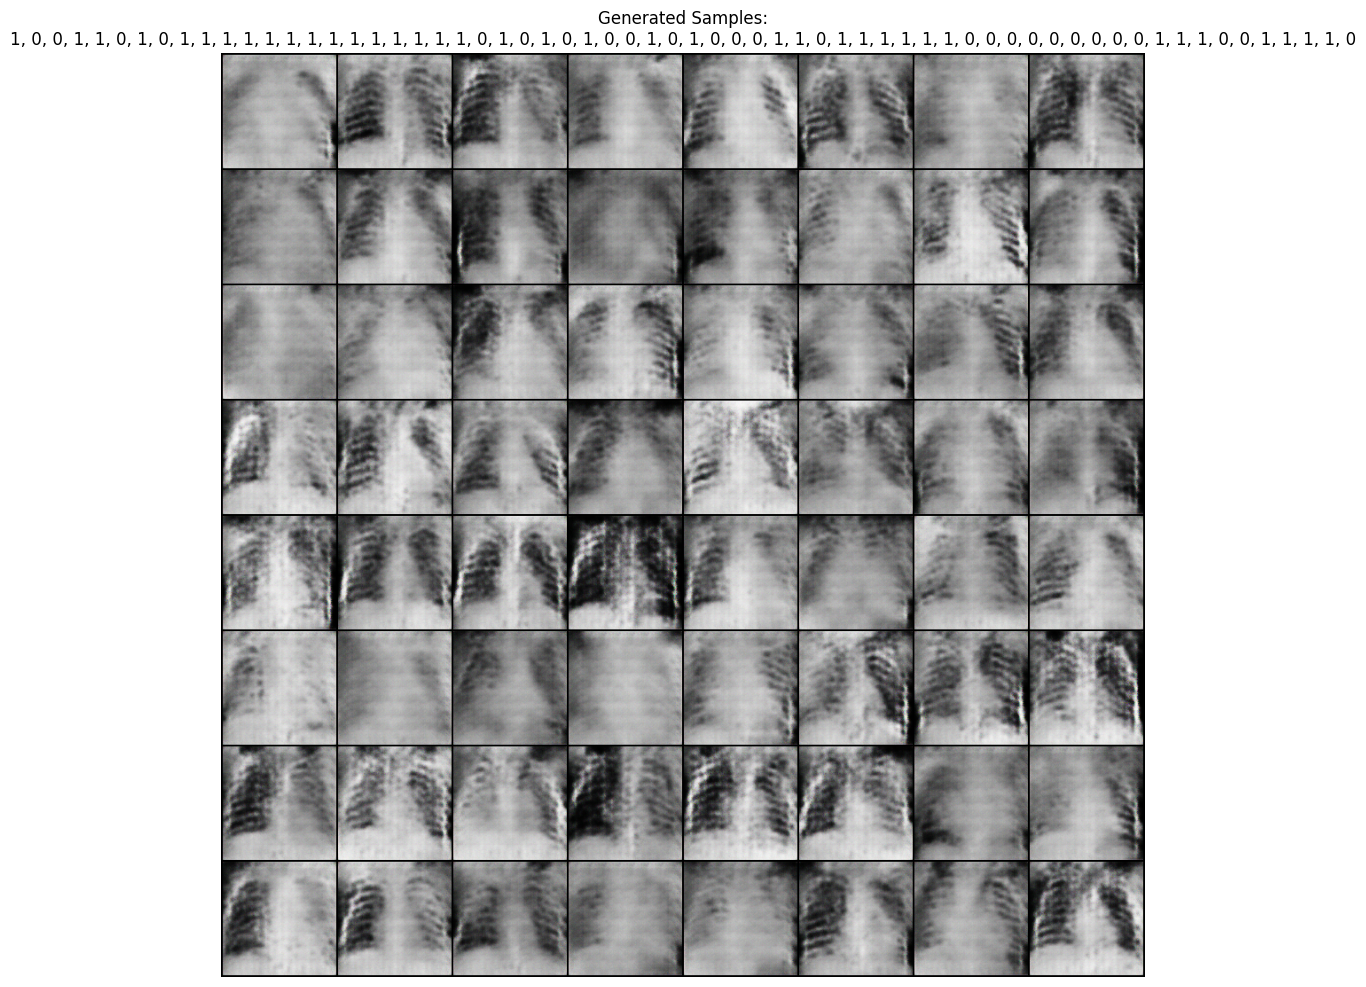

In [ ]:
fixed_noise = torch.randn(64, latent_dim, device=device)
fake_lbl = torch.randint(0, n_classes, (64,)).to(device)

print(fixed_noise.shape)
print(fake_lbl.shape)

with torch.no_grad():
  acgan_fake = acgan_G(fixed_noise, fake_lbl).detach().cpu()

grid = vutils.make_grid(acgan_fake, nrow=8, normalize=True, value_range=(-1, 1))

plt.figure(figsize=(12, 12))
plt.imshow(grid.permute(1,2,0).cpu().numpy().squeeze(), cmap='gray')
plt.title('Generated Samples:\n' + ', '.join(str(l.item()) for l in fake_lbl))
plt.axis('off')
plt.show()

torch.Size([64, 100])
torch.Size([64])
torch.Size([64, 3, 128, 128])


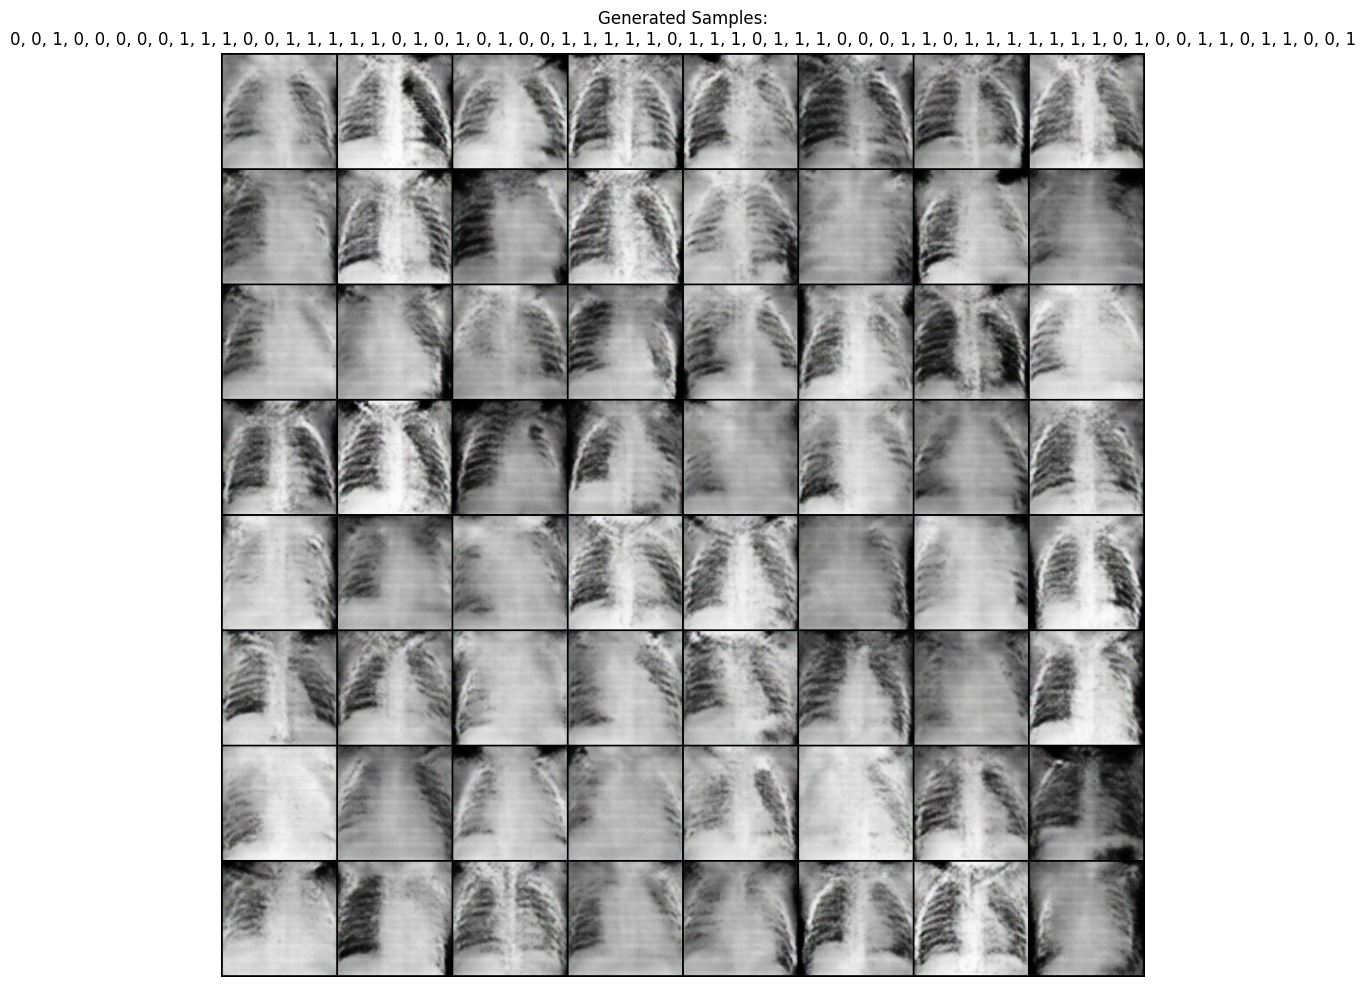

In [ ]:
fixed_noise = torch.randn(64, latent_dim, device=device)
fake_lbl = torch.randint(0, n_classes, (64,)).to(device)

print(fixed_noise.shape)
print(fake_lbl.shape)

with torch.no_grad():
  medganx_fake = medganx_G(fixed_noise, fake_lbl).detach().cpu()
  print(medganx_fake.shape)

grid = vutils.make_grid(medganx_fake, nrow=8, normalize=True, value_range=(-1, 1))

plt.figure(figsize=(12, 12))
plt.imshow(grid.permute(1,2,0).cpu().numpy().squeeze(), cmap='gray')
plt.title('Generated Samples:\n' + ', '.join(str(l.item()) for l in fake_lbl))
plt.axis('off')
plt.show()

In [ ]:
test_ds = dset.ImageFolder(test_path, transform=transform)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=2)

train_ds = dset.ImageFolder(train_path, transform=transform)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
test_imgs, test_lbls = next(iter(test_loader))
test_imgs = test_imgs.to(device)

train_imgs, train_lbls = next(iter(train_loader))
train_imgs = train_imgs.to(device)

In [ ]:
print(test_imgs.shape)
print(acgan_fake.shape)

torch.Size([64, 3, 128, 128])
torch.Size([64, 3, 128, 128])


### FID
Lower is better, 0 is same

In [ ]:
def compute_fid(real_images, fake_images, device='cuda'):
    # 1. Load feature extractor
    feature_extractor = models.inception_v3(pretrained=True)
    feature_extractor.fc = nn.Identity()  # remove final classifier
    feature_extractor = feature_extractor.to(device).eval()

    # 3. Get features
    real_feats = feature_extractor(real_images)
    fake_feats = feature_extractor(fake_images)

    # 4. Compute statistics
    mu_real = real_feats.mean(0)
    sigma_real = torch.cov(real_feats).detach().cpu().numpy()

    mu_fake = fake_feats.mean(0)
    sigma_fake = torch.cov(fake_feats).detach().cpu().numpy()

    # 6. FID
    ssdiff = torch.sum((mu_real - mu_fake)**2.0)
    covmean, _ = sqrtm(sigma_real @ sigma_fake, disp=False)

    # If imaginary numbers are introduced, take only the real part
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma_real + sigma_fake - 2.0 * covmean)
    return fid

In [ ]:
fid_score = compute_fid(train_imgs, train_imgs, device=device)
print(f"FID (same): {fid_score:.2f}")

FID (same): -0.00


In [ ]:
fid_score = compute_fid(train_imgs, test_imgs, device=device)
print(f"FID (train vs test): {fid_score:.2f}")

FID (train vs test): 100.06


In [ ]:
fid_score = compute_fid(test_imgs, acgan_fake.to(device), device=device)
print(f"FID (test vs baseline gan): {fid_score:.2f}")

FID (test vs baseline gan): 718.74


In [ ]:
fid_score = compute_fid(test_imgs, medganx_fake.to(device), device=device)
print(f"FID (test vs medganx): {fid_score:.2f}")

FID (test vs medganx): 596.54


### SSIM
Higher is better, 1 is same

In [ ]:
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(images1, images2):
    # calculate activations
    feature_extractor = models.inception_v3(pretrained=True)
    feature_extractor.fc = nn.Identity()  # remove final classifier
    feature_extractor = feature_extractor.to(device).eval()
    act1 = feature_extractor(images1).detach().cpu().numpy()
    act2 = feature_extractor(images2).detach().cpu().numpy()

    # calculate SSIM for each pair of corresponding activations
    ssim_values = [ssim(a1, a2, data_range=a2.max() - a2.min()) for a1, a2 in zip(act1, act2)]

    # return mean SSIM value
    return np.mean(ssim_values)

In [ ]:
ssim_score = calculate_ssim(train_imgs, train_imgs)
print(f"SSIM (same): {ssim_score:.2f}")

SSIM (same): 1.00


In [ ]:
ssim_score = calculate_ssim(train_imgs, test_imgs)
print(f"SSIM (train vs test): {ssim_score:.2f}")


SSIM (train vs test): 0.33


In [ ]:
ssim_score = calculate_ssim(test_imgs, acgan_fake.to(device))
print(f"SSIM (test vs baseline gan): {ssim_score:.2f}")

SSIM (test vs baseline gan): 0.22


In [ ]:
ssim_score = calculate_ssim(test_imgs, medganx_fake.to(device))
print(f"SSIM (test vs medganx): {ssim_score:.2f}")

SSIM (test vs medganx): 0.25
